In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import nibabel as nb
from nighres.io import io_mesh
import matplotlib.pyplot as plt
import gdist
import seaborn as sns

In [3]:
data_dir = '/home/julia/data/gradients/results/'

In [4]:
hpc_mesh = io_mesh.load_mesh(data_dir+'origins/hippocampus_sampled_mesh.vtk')
piri_mesh = io_mesh.load_mesh(data_dir+'origins/piriform_sampled_mesh.vtk')
gradients_mesh = io_mesh.load_mesh(data_dir+'embedding/embed_sampled_mesh.vtk')
cortex = np.where(gradients_mesh['data'][:,0]!=0)[0]

### Calculate geodesic distance from the two origins, projected onto the surface

In [5]:
source = np.where(hpc_mesh['data']>0)[0]
dist = gdist.compute_gdist(np.array(gradients_mesh['points'], dtype=np.float64), 
                           np.array(gradients_mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros((gradients_mesh['data'].shape[0]))
dist_mesh[cortex] = dist
io_mesh.save_mesh(data_dir+'origins/hippocampus_dist.vtk', 
                  {'points':gradients_mesh['points'], 'faces':gradients_mesh['faces'], 'data':dist_mesh})

In [6]:
source = np.where(piri_mesh['data']>0)[0]
dist = gdist.compute_gdist(np.array(gradients_mesh['points'], dtype=np.float64), 
                           np.array(gradients_mesh['faces'], dtype=np.int32), 
                           source_indices=np.array(source, dtype=np.int32),
                           target_indices=np.array(cortex, dtype=np.int32))
dist[dist==np.inf] = 0
dist_mesh = np.zeros((gradients_mesh['data'].shape[0]))
dist_mesh[cortex] = dist
io_mesh.save_mesh(data_dir+'origins/piriform_dist.vtk', 
             {'points':gradients_mesh['points'], 'faces':gradients_mesh['faces'], 'data':dist_mesh})

In [7]:
hpc_dist = io_mesh.load_mesh(data_dir+'origins/hippocampus_dist.vtk')['data']
piri_dist = io_mesh.load_mesh(data_dir+'origins/piriform_dist.vtk')['data']

In [8]:
dist_combined = np.zeros((gradients_mesh['data'].shape[0],1))
dist_combined[cortex] = - hpc_dist[cortex] + piri_dist[cortex]
io_mesh.save_mesh(data_dir+'origins/combined_dist.vtk', 
             {'points':gradients_mesh['points'], 'faces':gradients_mesh['faces'], 'data':dist_combined})

In [9]:
dist_combined=io_mesh.load_mesh(data_dir+'origins/combined_dist.vtk')['data']

### Zones

In [10]:
zones_mesh = np.zeros((gradients_mesh['data'].shape[0],1))
zones_mesh[hpc_dist < piri_dist] = 1
zones_mesh[hpc_dist > piri_dist] = -1
io_mesh.save_mesh(data_dir+'origins/zones.vtk', 
             {'points':gradients_mesh['points'], 'faces':gradients_mesh['faces'], 'data':zones_mesh})


In [11]:
zones = io_mesh.load_mesh(data_dir+'origins/zones.vtk')
masked_zones = np.squeeze(zones['data'][cortex])

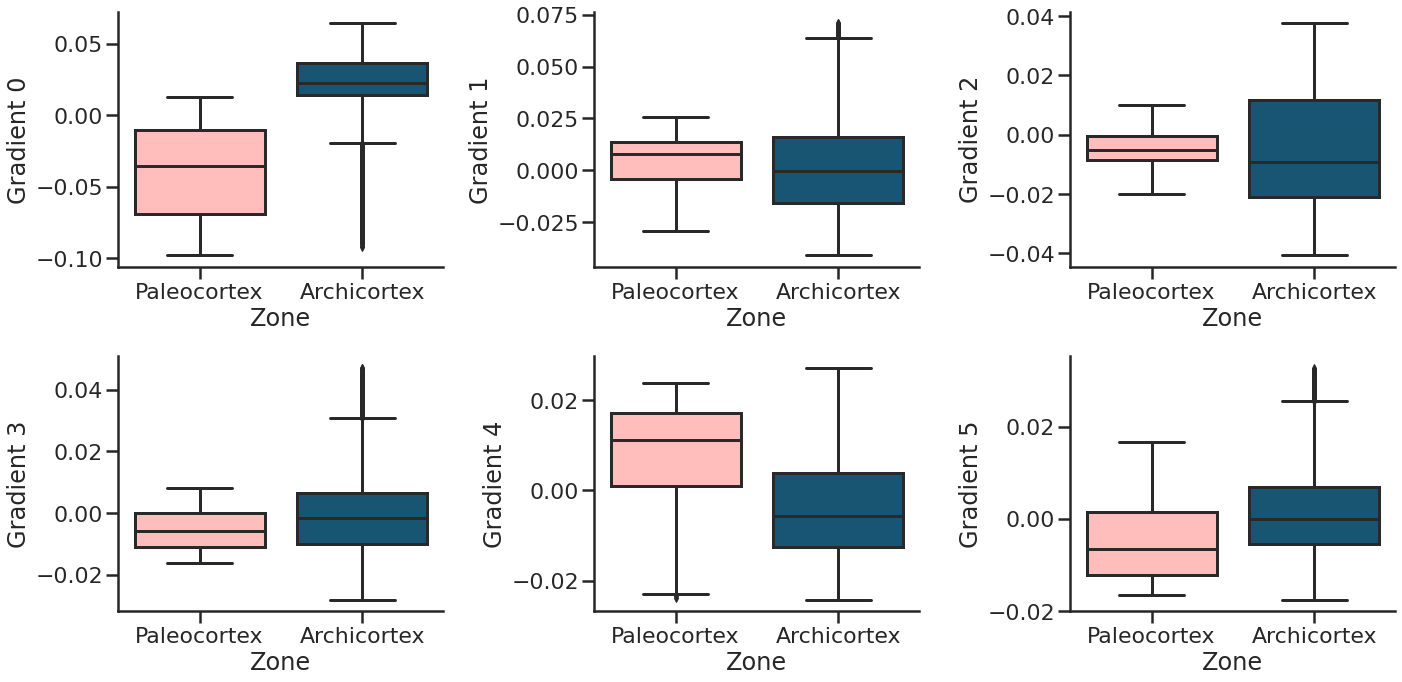

In [18]:
fig = plt.figure(figsize=(20,10))
sns.set_style('ticks')
sns.set_context('poster')

for g in range(6):
    piri_zone = gradients_mesh['data'][:,g][cortex][masked_zones==-1]
    hpc_zone = gradients_mesh['data'][:,g][cortex][masked_zones==1]

    data = pd.DataFrame()
    data['Gradient %i' % g] = np.concatenate((piri_zone, hpc_zone))
    data['Zone'] = piri_zone.shape[0] * ['Paleocortex'] + hpc_zone.shape[0] * ['Archicortex']
    pal = sns.color_palette([(1, 190/255, 187/255),
                             (24/255, 85/255, 114/255)])

    fig.add_subplot(2,3,g+1)
    sns.boxplot(x="Zone", y="Gradient %i" %g ,data=data, palette=pal, saturation=1)
    sns.despine()
    plt.tight_layout()
    # plt.yticks([-0.1, -0.05, 0.0, 0.05])
    # fig.savefig("/home/julia/data/gradients/pics/zones.svg")